In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import truncnorm, gamma, norm, cosine, invgamma, gennorm
import scipy.special as sc
from tqdm import tqdm
import math
import torch
import pickle

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
#read in the raw data from just 2023
from google.colab import drive
drive.mount('/drive')

raw23= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

field_dims = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/field_dims.csv')

Mounted at /drive


In [3]:
#read in the shift ban positioning recs
pos = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/positioning_optimization/recs_2023.csv')

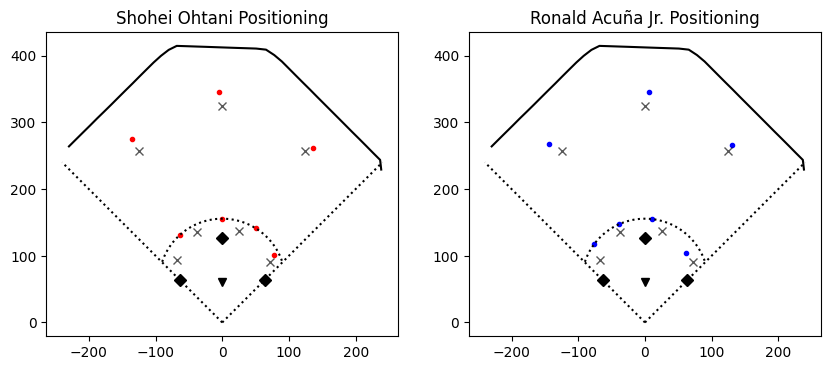

In [4]:
#plot some hitters
standard_pos = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
circ = np.linspace(-90, 90, 100)
mound = [0, 60.5]
shohei = pos.loc[pos.batter_id == 660271]
acuna = pos.loc[pos.batter_id == 660670]
trop_dims = field_dims.loc[field_dims.stadium == 'Tropicana Field']
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in range(7):
    ax1.plot(shohei['x' + str(i + 3)], shohei['y' + str(i+3)], 'r.', label = 'Shohei Ohtani')
    ax2.plot(acuna['x' + str(i + 3)], acuna['y' + str(i+3)], 'b.', label = 'Ronald Acuña Jr.')
    ax1.plot([standard_pos[2*i]], [standard_pos[2*i+1]], 'kx', alpha = 0.65)
    ax2.plot([standard_pos[2*i]], [standard_pos[2*i+1]], 'kx', alpha = 0.65)
ax1.plot([mound[0]], [mound[1]], 'kv')
ax1.plot(bases_x, bases_y, 'kD')
ax1.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
ax1.plot([0,240], [0,240], 'k:')
ax1.plot([0,-240], [0,240], 'k:')
ax1.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
ax1.set_aspect('equal')
ax2.plot([mound[0]], [mound[1]], 'kv')
ax2.plot(bases_x, bases_y, 'kD')
ax2.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
ax2.plot([0,240], [0,240], 'k:')
ax2.plot([0,-240], [0,240], 'k:')
ax2.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
ax2.set_aspect('equal')
ax1.set_title('Shohei Ohtani Positioning')
ax2.set_title('Ronald Acuña Jr. Positioning')
plt.show()

In [5]:
all_data = raw23
del raw23

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1

<ipython-input-5-5a5d784fb324>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['la_type'] = 0 #gb
<ipython-input-5-5a5d784fb324>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['is_gb'] = 0
<ipython-input-5-5a5d784fb324>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [6]:
#merge with pos to get positioning recs
df = all_data.merge(pos, left_on = ['batter', 'bat_handR'], right_on = ['batter_id', 'bat_handR'])

In [7]:
#calculate angles
df['a3'] = np.arctan2(df.x3.values, df.y3.values)*180/np.pi
df['a4'] = np.arctan2(df.x4.values, df.y4.values)*180/np.pi
df['a5'] = np.arctan2(df.x5.values, df.y5.values)*180/np.pi
df['a6'] = np.arctan2(df.x6.values, df.y6.values)*180/np.pi
df['a7'] = np.arctan2(df.x7.values, df.y7.values)*180/np.pi
df['a8'] = np.arctan2(df.x8.values, df.y8.values)*180/np.pi
df['a9'] = np.arctan2(df.x9.values, df.y9.values)*180/np.pi

#calculate depths
df['d3'] = np.sqrt(df.x3.values**2 + df.y3.values**2)
df['d4'] = np.sqrt(df.x4.values**2 + df.y4.values**2)
df['d5'] = np.sqrt(df.x5.values**2 + df.y5.values**2)
df['d6'] = np.sqrt(df.x6.values**2 + df.y6.values**2)
df['d7'] = np.sqrt(df.x7.values**2 + df.y7.values**2)
df['d8'] = np.sqrt(df.x8.values**2 + df.y8.values**2)
df['d9'] = np.sqrt(df.x9.values**2 + df.y9.values**2)

#calculate angular distance
df['ad3'] = df.a3.values - df.hit_direction.values
df['ad4'] = df.a4.values - df.hit_direction.values
df['ad5'] = df.a5.values - df.hit_direction.values
df['ad6'] = df.a6.values - df.hit_direction.values

#get the closest infielder by angle, their angle, and their depth. We're going to ignore the catcher and pitcher because obviously their positions are fixed
df['closest_infielder'] = np.argmin(np.abs(df[['ad3', 'ad4', 'ad5', 'ad6']].values),axis=1)  + 3
#get the corresponding coordinates for that infielder, and depth, and angle.
df['closest_infielder_angle'] = np.nan
df['closest_infielder_depth'] = np.nan
df['closest_infielder_angle_diff'] = np.nan
for i in range(3,7):
    df.loc[df.closest_infielder == i, ['closest_infielder_angle', 'closest_infielder_depth', 'closest_infielder_angle_diff']] = df.loc[df.closest_infielder == i, ['a' + str(i), 'd' + str(i), 'ad' + str(i)]].values

In [8]:
#predict the landing spots and hang times
model_t = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/hangtime_model.pkl', 'rb'))
model_dist = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/landing_dist_model.pkl', 'rb'))

df['hangtime'] = model_t.predict(df[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
df['distance'] = model_dist.predict(df[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
df['landing_x'] = df.distance.values * np.sin(np.pi * df.hit_direction.values / 180)
df['landing_y'] = df.distance.values * np.cos(np.pi * df.hit_direction.values / 180)

#also predict xwoba given a hit for all batted balls. WE will use this to prioritize higher xwoba balls in our optimizer
xwoba_mod = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/xwoba_model.pkl', 'rb'))
#I used fangraphs 2023 woba weights
df['xwoba'] = xwoba_mod.predict_proba(df[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values) @ np.array([0.883, 1.244, 1.569, 2.004])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:00:52] WARNING: /workspace/src/gbm/gbtree.cc:360: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:00:52] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:00:52] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [9]:
#calculate distance to landing spot of ball
df['dist3'] = np.sqrt((df.x3.values - df.landing_x.values)**2 + (df.y3.values - df.landing_y.values)**2)
df['dist4'] = np.sqrt((df.x4.values - df.landing_x.values)**2 + (df.y4.values - df.landing_y.values)**2)
df['dist5'] = np.sqrt((df.x5.values - df.landing_x.values)**2 + (df.y5.values - df.landing_y.values)**2)
df['dist6'] = np.sqrt((df.x6.values - df.landing_x.values)**2 + (df.y6.values - df.landing_y.values)**2)
df['dist7'] = np.sqrt((df.x7.values - df.landing_x.values)**2 + (df.y7.values - df.landing_y.values)**2)
df['dist8'] = np.sqrt((df.x8.values - df.landing_x.values)**2 + (df.y8.values - df.landing_y.values)**2)
df['dist9'] = np.sqrt((df.x9.values - df.landing_x.values)**2 + (df.y9.values - df.landing_y.values)**2)

#get the closest fielder by landing spot
df['closest_fielder'] = np.argmin(df[['dist3', 'dist4', 'dist5', 'dist6', 'dist7', 'dist8', 'dist9']].values, axis = 1) + 3
df['closest_fielder_x'] = np.nan
df['closest_fielder_y'] = np.nan
df['closest_fielder_angle'] = np.nan
df['closest_fielder_depth'] = np.nan
df['closest_fielder_coords_diff'] = np.nan
for i in range(3,10):
    df.loc[df.closest_fielder == i, ['closest_fielder_x', 'closest_fielder_y', 'closest_fielder_angle', 'closest_fielder_depth', 'closest_fielder_coords_diff']]= df.loc[df.closest_fielder==i, ['x' + str(i), 'y' + str(i), 'a' + str(i), 'd' + str(i), 'dist' + str(i)]].values

In [10]:
df['outcome'] = -1
df.loc[df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 'sac_bunt',
                                               'sac_fly_double_play']), 'outcome'] = 0 # in play out
df.loc[df.events == 'single', 'outcome'] = 1 #single
df.loc[df.events == 'double', 'outcome'] = 2 # double
df.loc[df.events == 'triple', 'outcome'] = 3 #triple
df.loc[df.events == 'home_run', 'outcome'] = 4 #hr

df['is_out'] = 0
df.loc[df.outcome == 0, 'is_out'] = 1

In [11]:
#remove home runs.
df = df.loc[df.outcome != 4]

#remove plays with baserunners as well, since that adds extra constraints to the fielding positions
df = df.loc[(np.isnan(df.on_3b)) & (np.isnan(df.on_2b)) &(np.isnan(df.on_1b))]

In [12]:
#remove the balls that likely get out of Tropicana Field since we optimized for the Trop
trop_dims = field_dims.loc[field_dims.stadium == 'Tropicana Field']
trop_dims['angle'] = np.arctan2(trop_dims.x.values, trop_dims.y.values)*180/np.pi
df['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(df.hit_direction.values[i] - trop_dims.angle.values))] for i in range(df.shape[0])]
df= df.loc[df.distance < df.wall_distance]

<ipython-input-12-063c94703c2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trop_dims['angle'] = np.arctan2(trop_dims.x.values, trop_dims.y.values)*180/np.pi


In [13]:
#we're going to compare to the average positioning we used to train the outs models, so remove the same plays
df = df.loc[df.of_fielding_alignment == 'Standard']

In [14]:
#calculate expected outs given our positioning recommendatiosn
df['abs_angle_diff'] = np.abs(df.closest_infielder_angle_diff.values)
df['ev_angle_inter'] = df.launch_speed.values * df.abs_angle_diff.values
df['bttf'] = df.closest_infielder_depth.values / (df.launch_speed.values * 1.4667)
df['time_diff'] = df.hangtime.values - df.closest_fielder_coords_diff.values/27
df['closest_fielder_backwards'] = 0
df.loc[df.closest_fielder_depth < df.distance, 'closest_fielder_backwards'] = 1
df['back_time_inter'] = df.time_diff.values*df.closest_fielder_backwards.values

gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977

fb_int = -2.16869748
fb_td_slope = 1.50402427

df['xout_prob'] = df.is_gb.values * sc.expit(gb_int + gb_angle_diff * df.abs_angle_diff.values + gb_bttf * df.bttf.values + gb_bttf2 * df.bttf.values**2) + (1-df.is_gb.values) * sc.expit(fb_int + fb_td_slope*df.time_diff.values)

In [15]:
df.shape

(62552, 167)

In [42]:
1-df.xout_prob.mean(), ((1-df.xout_prob.values) * df.xwoba.values).mean()

(0.3051740392270841, 0.3082272809891468)

In [43]:
1-df.is_out.mean()

0.29310014068295176

In [44]:
gb = df.loc[df.is_gb==1]
1-gb.xout_prob.mean(), 1-gb.is_out.mean()

(0.2569192355469794, 0.27395329467918117)

In [45]:
fb = df.loc[df.is_gb!=1]
1-fb.xout_prob.mean(), 1-fb.is_out.mean()

(0.3532471270356635, 0.3121748843146641)

In [46]:
#now we compare to the average positioning from the flyball/groundball outs models
#initialize infielder depths and angles
df[['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']]= np.array([34, 12, -32,-13,111,148,119,147, -27, 0, 27, 297, 322, 294])

df.loc[(df.bat_handR == 0) & (df.if_fielding_alignment == 'Infield shade'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([42, 20, -22.5, -5, 126, 147, 132, 152, -27,-1,27,297,323,294])
df.loc[(df.bat_handR == 0) & (df.if_fielding_alignment == 'Standard'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([42, 20, -27, -7.5, 124, 148, 117, 152, -30, -5, 26, 293, 329, 302])

df.loc[(df.bat_handR == 1) & (df.if_fielding_alignment == 'Infield shade'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([28, 5, -42.5, -20, 116, 154, 125, 145, -27, 1, 27, 303,323,291])
df.loc[(df.bat_handR == 1) & (df.if_fielding_alignment == 'Standard'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([30, 7.5, -42.5, -20, 116, 153, 118, 148, -25,5,29,300,321,293])

#use angle and depth to calculate coordinates
df['x3'] = df.d3.values * np.sin(np.pi * df.a3.values / 180)
df['y3'] = df.d3.values * np.cos(np.pi * df.a3.values / 180)
df['x4'] = df.d4.values * np.sin(np.pi * df.a4.values / 180)
df['y4'] = df.d4.values * np.cos(np.pi * df.a4.values / 180)
df['x5'] = df.d5.values * np.sin(np.pi * df.a5.values / 180)
df['y5'] = df.d5.values * np.cos(np.pi * df.a5.values / 180)
df['x6'] = df.d6.values * np.sin(np.pi * df.a6.values / 180)
df['y6'] = df.d6.values * np.cos(np.pi * df.a6.values / 180)
df['x7'] = df.d7.values * np.sin(np.pi * df.a7.values / 180)
df['y7'] = df.d7.values * np.cos(np.pi * df.a7.values / 180)
df['x8'] = df.d8.values * np.sin(np.pi * df.a8.values / 180)
df['y8'] = df.d8.values * np.cos(np.pi * df.a8.values / 180)
df['x9'] = df.d9.values * np.sin(np.pi * df.a9.values / 180)
df['y9'] = df.d9.values * np.cos(np.pi * df.a9.values / 180)

#calculate distance to landing spot of ball
df['dist3'] = np.sqrt((df.x3.values - df.landing_x.values)**2 + (df.y3.values - df.landing_y.values)**2)
df['dist4'] = np.sqrt((df.x4.values - df.landing_x.values)**2 + (df.y4.values - df.landing_y.values)**2)
df['dist5'] = np.sqrt((df.x5.values - df.landing_x.values)**2 + (df.y5.values - df.landing_y.values)**2)
df['dist6'] = np.sqrt((df.x6.values - df.landing_x.values)**2 + (df.y6.values - df.landing_y.values)**2)
df['dist7'] = np.sqrt((df.x7.values - df.landing_x.values)**2 + (df.y7.values - df.landing_y.values)**2)
df['dist8'] = np.sqrt((df.x8.values - df.landing_x.values)**2 + (df.y8.values - df.landing_y.values)**2)
df['dist9'] = np.sqrt((df.x9.values - df.landing_x.values)**2 + (df.y9.values - df.landing_y.values)**2)

#get the closest fielder by landing spot
df['closest_fielder'] = np.argmin(df[['dist3', 'dist4', 'dist5', 'dist6', 'dist7', 'dist8', 'dist9']].values, axis = 1) + 3
df['closest_fielder_x'] = np.nan
df['closest_fielder_y'] = np.nan
df['closest_fielder_angle'] = np.nan
df['closest_fielder_depth'] = np.nan
df['closest_fielder_coords_diff'] = np.nan
for i in range(3,10):
    df.loc[df.closest_fielder == i, ['closest_fielder_x', 'closest_fielder_y', 'closest_fielder_angle', 'closest_fielder_depth', 'closest_fielder_coords_diff']]= df.loc[df.closest_fielder==i, ['x' + str(i), 'y' + str(i), 'a' + str(i), 'd' + str(i), 'dist' + str(i)]].values

#calculate angular distance
df['ad3'] = df.a3.values - df.hit_direction.values
df['ad4'] = df.a4.values - df.hit_direction.values
df['ad5'] = df.a5.values - df.hit_direction.values
df['ad6'] = df.a6.values - df.hit_direction.values

#get the closest infielder by angle, their angle, and their depth. We're going to ignore the catcher and pitcher because obviously their positions are fixed
df['closest_infielder'] = np.argmin(np.abs(df[['ad3', 'ad4', 'ad5', 'ad6']].values),axis=1)  + 3
#get the corresponding coordinates for that infielder, and depth, and angle.
df['closest_infielder_angle'] = np.nan
df['closest_infielder_depth'] = np.nan
df['closest_infielder_angle_diff'] = np.nan
for i in range(3,7):
    df.loc[df.closest_infielder == i, ['closest_infielder_angle', 'closest_infielder_depth', 'closest_infielder_angle_diff']] = df.loc[df.closest_infielder == i, ['a' + str(i), 'd' + str(i), 'ad' + str(i)]].values

In [47]:
#calculate expected outs given our positioning recommendatiosn
df['abs_angle_diff'] = np.abs(df.closest_infielder_angle_diff.values)
df['ev_angle_inter'] = df.launch_speed.values * df.abs_angle_diff.values
df['bttf'] = df.closest_infielder_depth.values / (df.launch_speed.values * 1.4667)
df['time_diff'] = df.hangtime.values - df.closest_fielder_coords_diff.values/27
df['closest_fielder_backwards'] = 0
df.loc[df.closest_fielder_depth < df.distance, 'closest_fielder_backwards'] = 1
df['back_time_inter'] = df.time_diff.values*df.closest_fielder_backwards.values

df['xout_prob_avg'] = df.is_gb.values * sc.expit(gb_int + gb_angle_diff * df.abs_angle_diff.values + gb_bttf * df.bttf.values + gb_bttf2 * df.bttf.values**2) + (1-df.is_gb.values) * sc.expit(fb_int + fb_td_slope*df.time_diff.values)

In [48]:
1-df.xout_prob.mean(), 1-df.xout_prob_avg.mean(), ((1-df.xout_prob.values) * df.xwoba.values).mean(), ((1-df.xout_prob_avg.values) * df.xwoba.values).mean()

(0.3051740392270841,
 0.31971279481310944,
 0.3082272809891468,
 0.32072408354328646)

In [49]:
gb = df.loc[df.is_gb==1]
1-gb.xout_prob.mean(), 1-gb.xout_prob_avg.mean()

(0.2569192355469794, 0.27986595554412086)

In [50]:
fb = df.loc[df.is_gb!=1]
1-fb.xout_prob.mean(), 1-fb.xout_prob_avg.mean()

(0.3532471270356635, 0.3594095805625911)